## Part 0: Imports

In [1]:
import requests
import os, re
from datetime import datetime
from bs4 import BeautifulSoup
import json
import random

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from unidecode import unidecode
from country_named_entity_recognition import find_countries
import country_converter as coco

from typing import List, Dict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import powerlaw
from community import community_louvain

c:\Users\floco\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Scraping the data

Our first mission was to scrap the data from nature.com and then preprocess it to get beautiful list of nodes (universities) and edges (collaborations between universities).

To do it, we decided to create a Scraper object with some functions to then be able to scrap the data easily.

In [2]:
# Scraper class for extracting universities and collaborations from nature.com articles
class Scraper:
    def __init__(self):
        # Initializing class variables
        self.base_url = "https://www.nature.com"
        self.universities = {}         # Dictionary to store universities and their occurrences
        self.collabs = {}              # Dictionary to store collaborations between universities
        self.mapping_univs = {}        # Mapping old university names to new names
        self.links_saved = []         # List to save article links used after

    # Method to load collaboration data from a JSON file
    def load_collabs(self, filename):
        with open(filename, 'r') as file:
            self.collabs = json.load(file)

    # Method to load universities data from a JSON file
    def load_universities(self, filename):
        with open(filename, 'r') as file:
            self.universities = json.load(file)

    # Method to load saved links from a JSON file
    def load_links(self, filename):
        with open(filename, 'r') as file:
            self.links_saved = json.load(file)

    # Method to save universities data to a JSON file
    def save_universities_in_file(self, preprocess=True):
        if preprocess:
            with open('universities.json', 'w') as fp:
                json.dump(self.universities, fp)
        else:
            with open('universities_without_preprocess.json', 'w') as fp:
                json.dump(self.universities, fp)

    # Method to save collaborations data to a JSON file
    def save_collabs_in_file(self):
        with open('collabs.json', 'w') as fp:
            json.dump(self.collabs, fp)

    # Method to save saved links to a JSON file
    def save_links_in_file(self):
        with open('links.json', 'w') as fp:
            json.dump(self.links_saved, fp)

    # Method to retrieve HTML content of a given URL and parse it using BeautifulSoup
    def retrieve_url(self, url: str) -> BeautifulSoup:
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        return soup

    # Method to create a mapping between old and new university names
    def create_map(self):
        for new_name in self.universities.keys():        
            for old_name in self.universities[new_name]['init_names']:
                if old_name not in self.mapping_univs:
                    self.mapping_univs[old_name] = new_name

    # Method to extract universities data from nature.com articles
    def extract_universities(self, subject):
        init_univs_len = len(self.universities)
        init_links_len = len(self.links_saved)
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject={subject}&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=True, collabs=False)
                else:
                    self.links_saved.append((atag['href'], subject))

                articles_counter += 1            
            page += 1
        print(f"Extracted {len(self.universities) - init_univs_len} universites and {len(self.links_saved) - init_links_len} links for {subject} ({articles_counter} articles).\n")

    # Method to extract collaborations data from nature.com articles
    def extract_collabs(self, subject):
        articles_counter = 1
        page = 1

        while True:
            search_url = f'{self.base_url}/search?journal=srep&article_type=research&subject={subject}&date_range=last_year&order=relevance&page={page}'
            soup = self.retrieve_url(search_url)

            all_atags = soup.find_all('a', {'data-track-action': 'view article'})

            if len(all_atags) == 0:
                break

            for atag in all_atags:
                random.seed(articles_counter)

                if(random.random() < 0.5):
                    self.parse_page(self.base_url + atag['href'], univs=False, collabs=True)
                articles_counter += 1  
            page += 1
        print(f"Extracted collabs in {articles_counter} articles for {subject}\n")

    # Method to print statistics about extracted data
    def print_stats(self):
        print(f'Number of nodes: {len(self.universities)}')
        links = 0
        links_with_fields = 0

        for u1 in self.collabs:
            for u2 in self.collabs[u1]:
                for u3 in self.collabs[u1][u2]:
                    links_with_fields += 1
                links += 1

        print(f'Number of links (without fields): {links}')
        print(f'Number of links (with fields): {links_with_fields}')

    # Method to parse the content of an article page and update dictionaries
    def parse_page(self, url: str, univs=True, collabs=True):
        soup = self.retrieve_url(url)

        try:
            # Find universities and update dictionaries
            authors_all = soup.findAll('p', class_='c-article-author-affiliation__address')
            subjects_all = soup.findAll('meta', {'name': 'dc.subject'})

            # If we want to extract university of authors
            if univs:
                for s in authors_all:        
                    university = s.text        
                    if university not in self.universities:
                        self.universities[university] = 1
                    else:
                        self.universities[university] += 1

            # If we want to extract collaborations between universities -> update self.collabs
            if collabs:
                for s in authors_all:
                    try:
                        university = self.mapping_univs[s.text]

                        if university not in self.collabs:
                            self.collabs[university] = {}

                        alreadyAddedUniv = []
                        for s2 in authors_all:
                            try:
                                other_university = self.mapping_univs[s2.text]
                                if other_university not in alreadyAddedUniv:
                                    if university != other_university:
                                            if other_university not in self.collabs[university]:
                                                self.collabs[university][other_university] = {}

                                            if subject not in self.collabs[university][other_university]:
                                                self.collabs[university][other_university][subject] = 0

                                            self.collabs[university][other_university][subject] += 1
                                    alreadyAddedUniv.append(other_university)
                            except:
                                continue
                    except:
                        continue

        except Exception as error:
            print("[ERROR] Parse page: ", error) 

    # Method to preprocess university data
    def preprocess_universities(self):
        universities = {}

        for entry, count in self.universities.items():
            # Split the entry by commas and iterate through the parts
            parts = entry.split(',')

            # Look for patterns that match university names
            university = None
            for part in reversed(parts):
                if any(keyword in part for keyword in ["Polytechnic", "NIT", "MIT", "Politecnico", "Escuela", "École", "Universitat", "Università", "Universität", "Universidad", "University", "Ecole", "Universiti", "Université", "College", "School"]):
                    university = part.strip()
                    break

            # If a university name is found, store the entry in the dictionary
            if university:
                if university in universities:
                    universities[university]['init_names'].append(entry)
                    universities[university]['count'] += count
                else:
                    universities[university] = {"init_names": [entry], "count": count, 'country': entry.split(',')[-1].strip()}
            # else:
            #     print(f"Not accepted this uni: {entry}")
        
        university_names = list(universities.keys())

        # Use a trained model to encode universities name and then do the cosine similarity
        model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
        embeddings = model.encode(university_names, convert_to_tensor=True)
        similarity_matrix = cosine_similarity(embeddings, embeddings)

        # Create similar pairs based on a threeshold on the cosine similarity
        threshold = 0.92
        similar_pairs = []

        for i in range(len(university_names)):
            for j in range(i + 1, len(university_names)):
                if similarity_matrix[i, j] > threshold:
                    similar_pairs.append((university_names[i], university_names[j]))

        # Then create similar groups
        similar_groups = []

        for pair in similar_pairs:
            found = False
            for group in similar_groups:
                if pair[0] in group or pair[1] in group:
                    group.add(pair[0])
                    group.add(pair[1])
                    found = True
                    break
            if not found:
                similar_groups.append({pair[0], pair[1]})

        similar_groups = [list(group) for group in similar_groups]

        # Create abstract names containing all the same groups universities
        for gr in similar_groups:
            first_uni = gr[0]

            if first_uni in universities:
                if 'init_names' not in universities[first_uni]:
                    universities[first_uni]['init_names'] = first_uni['init_names']
                if 'count' not in universities[first_uni]:
                    universities[first_uni]['count'] = first_uni['count']
                for uni in gr[1:]:
                    if uni in universities:
                        universities[first_uni]['init_names'].extend(universities[uni].get('init_names', []))
                        universities[first_uni]['count'] = universities.get(first_uni, {}).get('count', 0) + universities.get(uni, {}).get('count', 0)
                        if 'country' not in universities[first_uni] and 'country' in uni:
                            universities[first_uni]['country'] = uni['country']
                        
                        universities.pop(uni)
        
        # Manually fix some mistakes
        mistakes_in_countries = {
            'Brasil':'Brazil',
            'Espana':'Spain',
            'UAE': 'United arab emirates',
            'ROC': 'Taiwan',
            'Northern Ireland': 'Ireland'
        }

        # Use country converter to have same format for every countries
        cc = coco.CountryConverter()

        for uni, values in universities.items():
            #Clean unicode characters like egne
            country = unidecode(values['country'])
            #Clean spelling mistakes, or not recognized names
            country = mistakes_in_countries.get(country,country)
            convert_result = cc.convert(country, to = 'name_short')
            #If last part of string was not a good country, we take the string before
            if convert_result == 'not found':
                convert_result = cc.convert(values['init_names'][0].split(',')[-2], to = 'name_short')
                
            universities[uni]['country'] = convert_result

        # Remove leading and ending space
        universities = {key.strip(): value for key, value in universities.items()}

        self.universities = universities

## Part 2: Creation of the network

Now that we've implemented a scraper to acquire and preprocess data, we can construct our network. In this network, each node corresponds to a university along with its respective country. An edge in the network signifies a collaboration on a specific subject between two universities. The network is undirected.

Our approach involves creating individual edges for each subject-specific collaboration between universities. Additionally, we include an overarching edge between two universities, denoted by the subject attribute "All." The weight of this overall edge is set as the sum of the weights of all subject-specific collaborations between the two universities.

In [3]:
# Create scraper object and load universities / collabs
data = Scraper()
data.load_universities("universities.json")
data.load_collabs("collabs.json")

# Create the graph
G = nx.MultiGraph()

# Add nodes in the network
for uni in data.universities:
    G.add_node(uni, country= data.universities[uni]['country'])

# Add edges in the network
for source_uni, target_unis in data.collabs.items():
    for target_uni, collaborations in target_unis.items():
        if(target_uni in G.nodes() and source_uni in G.nodes()):
            overall_weight = 0
            for subject, weight in collaborations.items():
                G.add_edge(source_uni, target_uni, subject=subject, weight=weight)
                overall_weight += weight

            # Add the overall edge with field 'All' and the sum of subject weights as weight
            G.add_edge(source_uni, target_uni, subject='All', weight=overall_weight)


With our network now established, the next step involves eliminating isolated nodes from the graph. Isolated nodes refer to universities that do not engage in any collaborations within the given network context. Removing these nodes streamlines the network representation by focusing on interconnected universities, enhancing the clarity and relevance of the collaborative relationships within the system.

In [4]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes is {len(isolated_nodes)}")
G.remove_nodes_from(isolated_nodes)
print(f"Number of nodes after removal is {len(G.nodes())}")

Number of isolated nodes is 1126
Number of nodes after removal is 1905


## Part 3: Creation of the subgraphs based on subject

The next step is to create different networks (one for each subject).

To do this, we will start by defining a color coding for every subject, and use such color coding for visual representations.

We picked colors from the nature.com color coding, so
* for the field of physical sciences, we have shades of blue
* for the field of Earth and Environmental sciences, we have shades of green
* for the field of Biological sciences, we have shades of purple
* for the field of Health sciences, we have shades of red
* for the field "All", we will take the black

In [5]:
subj_color_mapping = {
    'health-care': '#FFBF00', #Orange, yellowish
    'mathematics-and-computing': '#00008B', #Blue
    'genetics': '#702963', #Purple
    'ecology': '#50C878', #Green
    'diseases': '#FF5F1F', #Orange danger
    'microbiology': '#CCCCFF',  #Purple
    'physics': '#7393B3', #Blue
    'All':'#000000' #Black
}

### Distribution of edges across different subjects

Now, we can proceed to generate a histogram to visualize the distribution of edges across different subjects. This will provide insights into the quantity of data available for each subject, allowing us to identify areas with more extensive collaboration data.

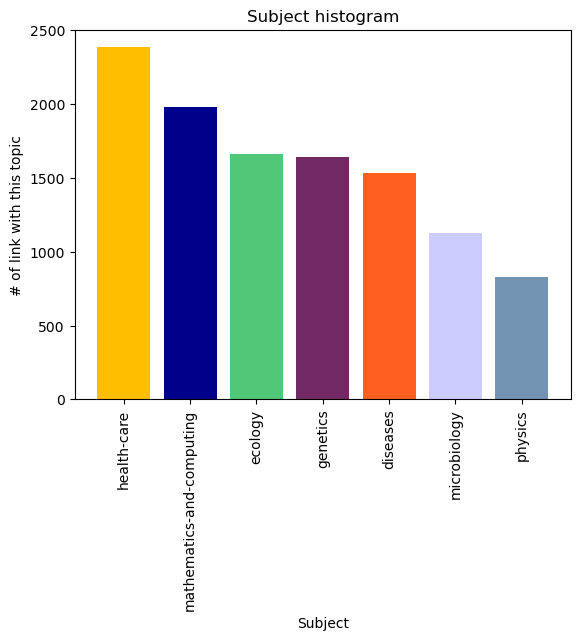

In [6]:
def subject_distribution(subjects, first_n):
    distrib = {}
    for subject, weight in subjects:
        if subject != 'All':
            distrib[subject] = distrib.get(subject,0) + weight
    width = 0.8 # width of the bars

    fig, ax = plt.subplots()

    ordered_items = sorted(distrib.items(),key=lambda x: x[1], reverse = True)[:first_n]
    xvalues = [subject for subject, value in ordered_items]
    yvalues = [value for subject, value in ordered_items]
    
    colors = [subj_color_mapping[subject] for subject in xvalues]

    rects1 = ax.bar(xvalues, yvalues, width, color=colors)
    ax.set_title("Subject histogram")
    ax.set_xlabel("Subject")
    ax.set_xticks(range(len(xvalues)),xvalues, rotation = 90) # set the position of the x ticks
    ax.set_ylabel("# of link with this topic")
    plt.show()


#Analyzing subjects
subjects = [(attr['subject'], attr['weight']) for node1, node2, attr in G.edges(data=True)]
first_n = 10
subject_distribution(subjects, first_n)
subject_set = set([subj for subj, weight in subjects])

Observing the histogram, it becomes evident that health-care and mathematics-and-computing are the two prominent fields, followed by the clusters of ecology, genetics, and diseases. In contrast, microbiology and physics exhibit a comparatively lower quantity of data. 

This observation leads to the conclusion that, if necessary, fields such as microbiology and physics could be considered for exclusion in subsequent analyses due to their relatively limited data representation.

### Creation of the subnetworks

Having gained a clearer understanding of the data distribution across subjects, our next step involves building subnetworks. Each subject will be represented as an individual network, and concurrently, we will create a comprehensive subnetwork encompassing all connections between universities, regardless of the subject. This approach allows us to explore both subject-specific collaborations and the overarching collaborative landscape across all subjects.

In [7]:
def create_subgraph(G, subj):
    edges = set([(node1, node2, key) for node1, node2 in G.edges() for key, value in G.get_edge_data(node1, node2).items() if value['subject'] == subj])
    graph = G.edge_subgraph(edges)

    # Remove isolated nodes
    isolated_nodes = list(nx.isolates(graph))    
    if isolated_nodes:
        graph.remove_nodes_from(isolated_nodes)

    return graph
    

In [8]:
graphs = {}
for subj in subj_color_mapping.keys():
    graphs[subj] = create_subgraph(G, subj)

### Creation of the degree distributions

Subsequently, we can access the desired graphs through the 'graphs' dictionary. Our next objective is to generate the corresponding degree distributions for each graph within this dictionary. This process entails examining the distribution of degrees, providing valuable insights into the connectivity patterns of universities within each subject-specific network.

In [9]:
def get_node_degree(graph, node):
    sum = 0
    for fr, to, d in graph.edges(node, data=True):
        sum = sum + d['weight']
    return sum

In [10]:
degrees = {}
sorted_degrees = {}
for subj in graphs:
    degrees[subj] = [(n, graphs[subj].nodes[n]['country'], get_node_degree(graphs[subj], n)) for n in graphs[subj].nodes]
    sorted_degrees[subj] = sorted(degrees[subj], key=lambda x: x[2], reverse=True)

## Part 4: Analysis of the subnetworks

Now that we have access to both graphs and degree distributions, the next phase involves initiating the analysis of networks to uncover any noteworthy patterns.

### Utilities functions for analysis

To facilitate this analysis, we'll begin by creating two utility functions – one for visually displaying informative bar charts and another for rendering network visualizations for each subject. These functions will serve as valuable tools in our exploration of potential patterns within the collaborative networks.

In [11]:
def populate_plot(data, subj, fig, grid, labels):
    dmax = max(data[:])
    dmin = min(data[:])
    
    #Bin plot
    bins = np.arange(dmin, dmax+2)
    hist, bins = np.histogram(data[:], bins)
    
    ax = fig.add_subplot(grid) 
    ax.bar(bins[:-1], hist, width=1, align='center', edgecolor='k', color = subj_color_mapping[subj])
    ax.set_title(f'{subj}')
    ax.set_xlabel(labels['xlabel'])
    ax.set_ylabel('How many')
    return ax

In [12]:
#Only requires subject associated with list of data to barplot
def create_visual_graph(subj_data_dict, labels, category='bar'):
    fig = plt.figure("Distribution", figsize=(15, 30))
    
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(4, 2)
    
    axes = []
    for i, grid in enumerate(axgrid):
        if category == 'bar':
            axes.append(populate_plot(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        if category == 'network2d':
            axes.append(drawNetwork2D(list(subj_data_dict.values())[i], list(subj_data_dict.keys())[i], fig, grid, labels))
        if category == 'network3d':
            graph = list(subj_data_dict.values())[i].subgraph(sorted(nx.connected_components(list(subj_data_dict.values())[i]), key=len, reverse=True)[0])
            positions = nx.spring_layout(graph, k=1.2, scale=8)
            axes.append(drawNetwork3D(graph, positions=positions, fig=fig, grid=grid, name=labels[i]))
    fig.tight_layout()
    plt.show()

### Count of Nodes and Edges and top 3 universities

To start our analysis, we'll start by examining the number of nodes and edges within each subnetwork. This initial exploration will provide us with fundamental insights into the structure and scale of each collaborative network

In [13]:
for subj in graphs:
    graph = graphs[subj]
    print(f"Graph on \033[1m{subj}\033[0m has {len(graph.nodes())} nodes and {len(graph.edges())} edges.")

Graph on health-care has 579 nodes and 1890 edges.
Graph on mathematics-and-computing has 493 nodes and 1734 edges.
Graph on genetics has 370 nodes and 1256 edges.
Graph on ecology has 358 nodes and 1546 edges.
Graph on diseases has 366 nodes and 1234 edges.
Graph on microbiology has 324 nodes and 938 edges.
Graph on physics has 259 nodes and 730 edges.
Graph on All has 1905 nodes and 8732 edges.


We can now get the top 3 universities for each subject.

In [14]:
for subj in graphs:
    print(f"Top 3 universities ({subj}):")
    for i, (name, country, degree) in enumerate([(name, country, degree) for name, country, degree in sorted_degrees[subj]][:3], 1):
        print(f"{i}. University: {name} ({country}), Number of collaborations: {degree}")
    print("")

Top 3 universities (health-care):
1. University: Seould National University College of Medicine (South Korea), Number of collaborations: 59
2. University: Lithuanian University of Health Sciences (Lithuania), Number of collaborations: 49
3. University: Seoul National University Hospital (South Korea), Number of collaborations: 44

Top 3 universities (mathematics-and-computing):
1. University: King Saud University (Saudi Arabia), Number of collaborations: 79
2. University: Princess Nourah Bint Abdulrahman University (Saudi Arabia), Number of collaborations: 72
3. University: Prince Sattam bin Abdulaziz University (Saudi Arabia), Number of collaborations: 70

Top 3 universities (genetics):
1. University: Kansai Medical University (Japan), Number of collaborations: 62
2. University: University of Miami Miller School of Medicine (United States), Number of collaborations: 47
3. University: King’s College London (United Kingdom), Number of collaborations: 45

Top 3 universities (ecology):
1.

TODO: OBSERVATIONS

### Degree distributions

Let's now draw all the degree distributions:

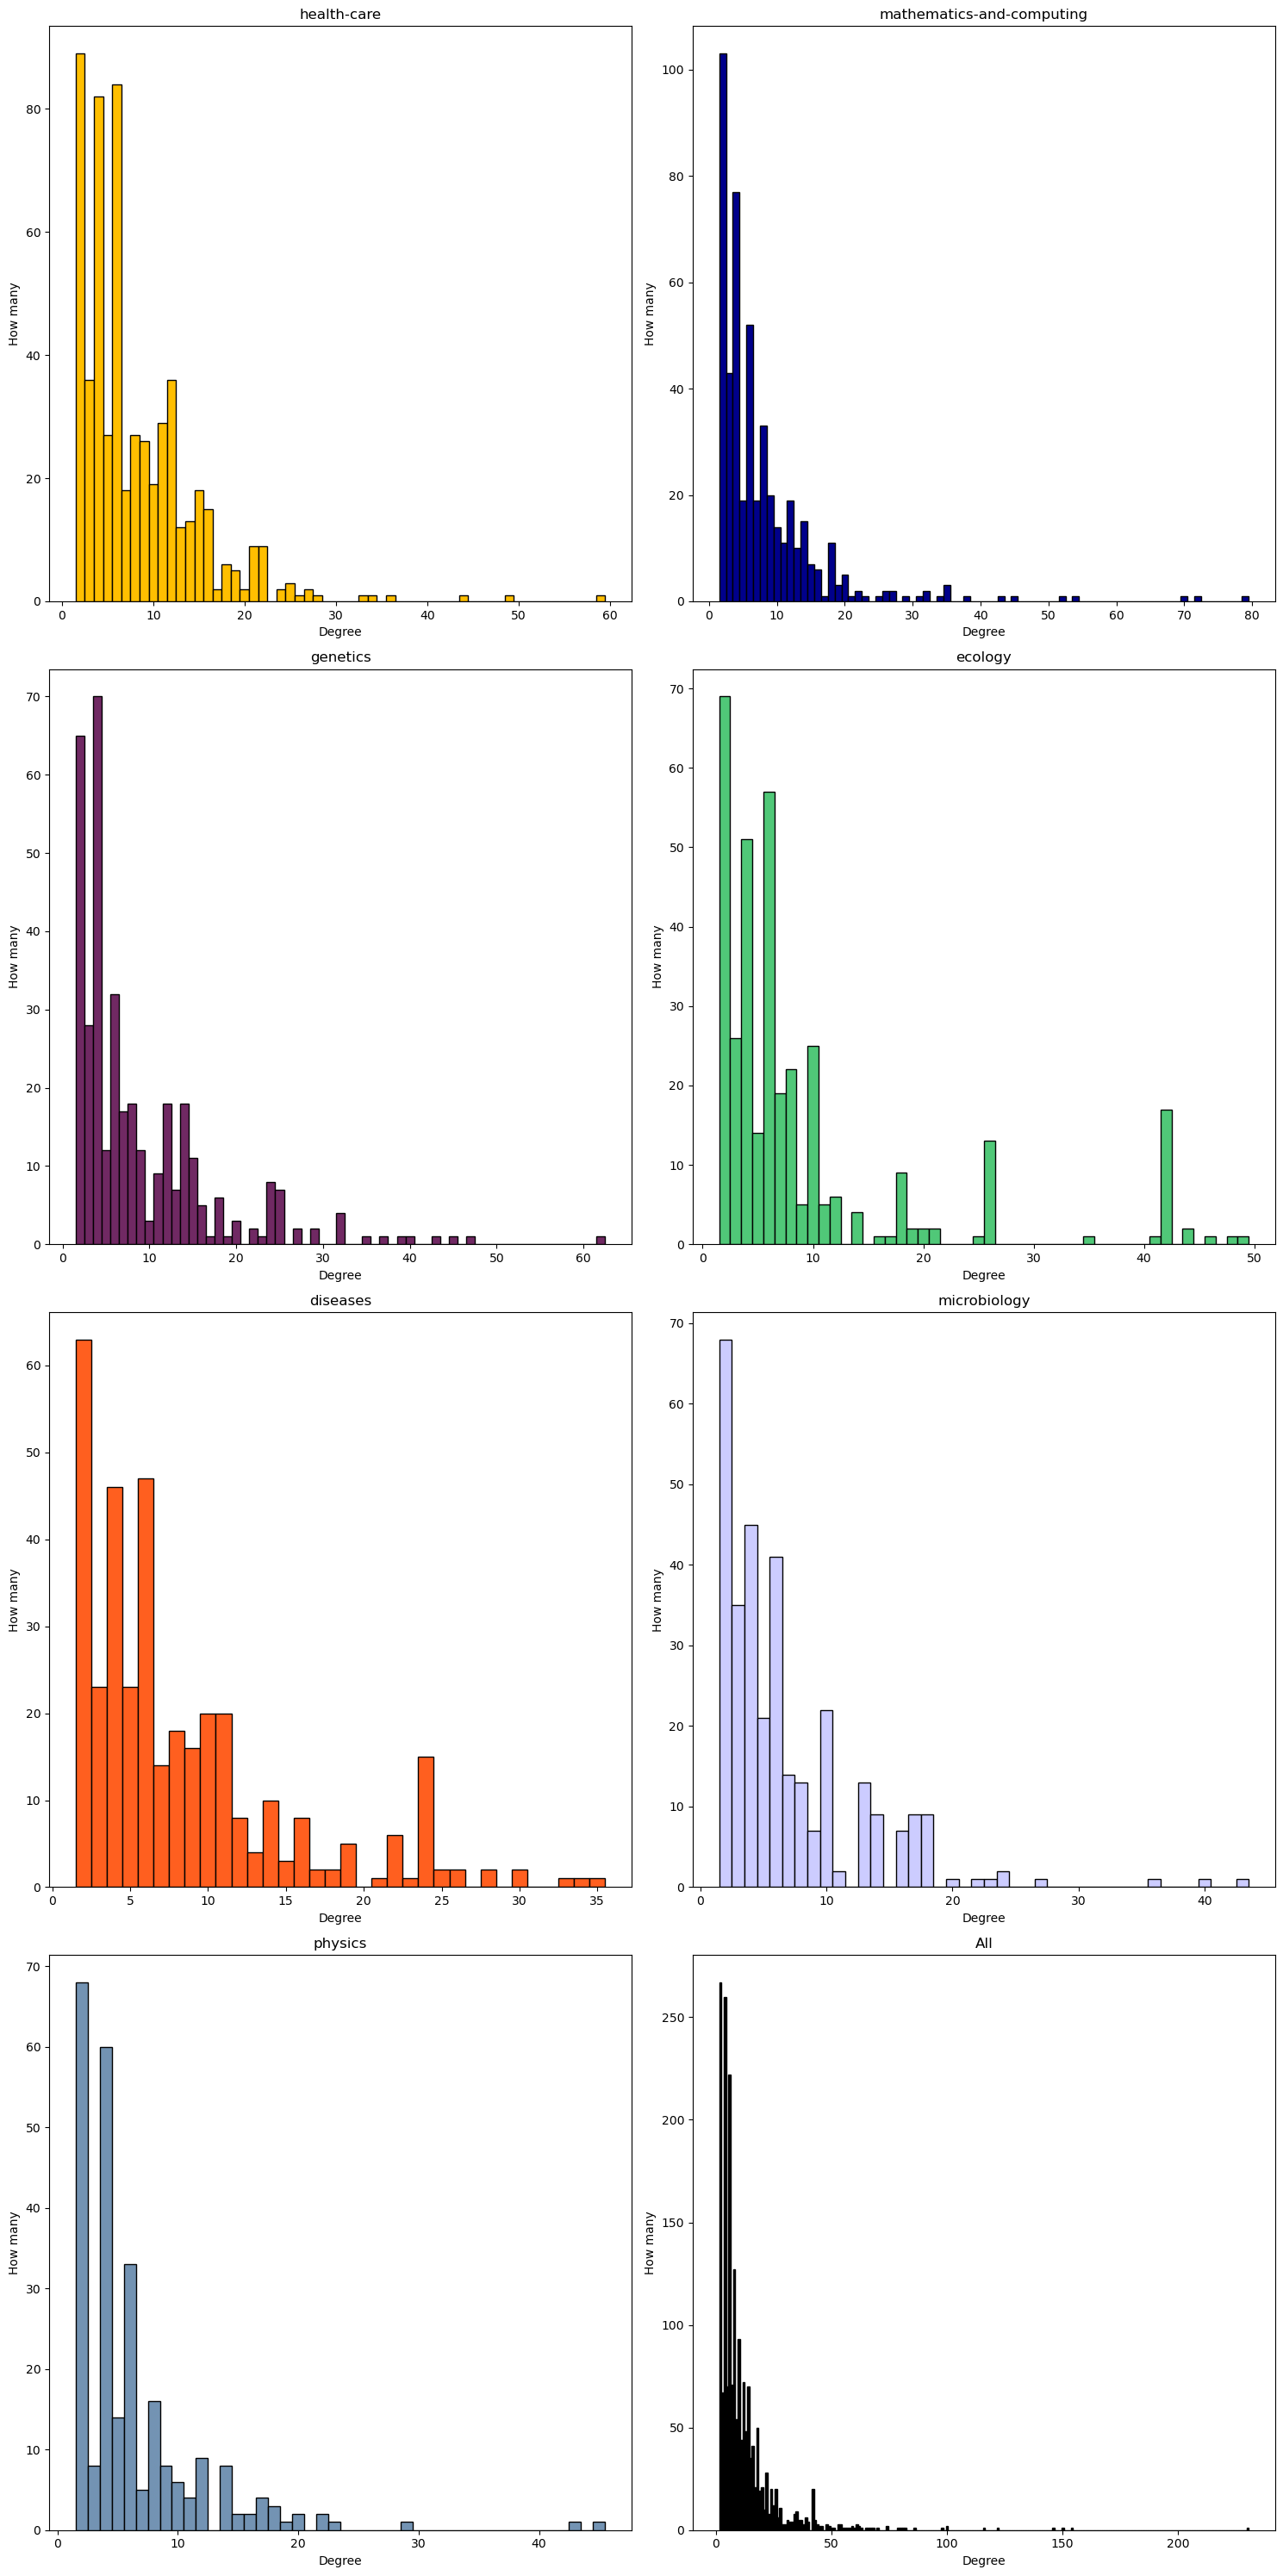

In [15]:
subj_degrees_dict = {}
labels = {'xlabel':'Degree'}
for subject, graph in graphs.items():
    subj_degrees_dict[subject] = list(map(lambda x: x[2], sorted_degrees[subject]))
    
create_visual_graph(subj_degrees_dict, labels, 'bar')

__TODO: COMMENTS ABOUT DEGREE DISTRIBUTIONS__ 

Let's now focus on the connected component, we can try to print the connected component size distribution for each subject.

__TODO: For future versions, maybe we need to fix the x range for the plots (?)__ 

In [16]:
##How many connected components? And how big are they?
def connected_component_size_distribution(G, subj):
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    print(f"Subject \033[1m{subj}\033[0m has {len(Gcc)} connected components")
    Gcc_len_distrib = [len(cc) for cc in Gcc]
    return Gcc_len_distrib

Subject health-care has 135 connected components
Subject mathematics-and-computing has 102 connected components
Subject genetics has 85 connected components
Subject ecology has 78 connected components
Subject diseases has 87 connected components
Subject microbiology has 96 connected components
Subject physics has 67 connected components
Subject All has 173 connected components


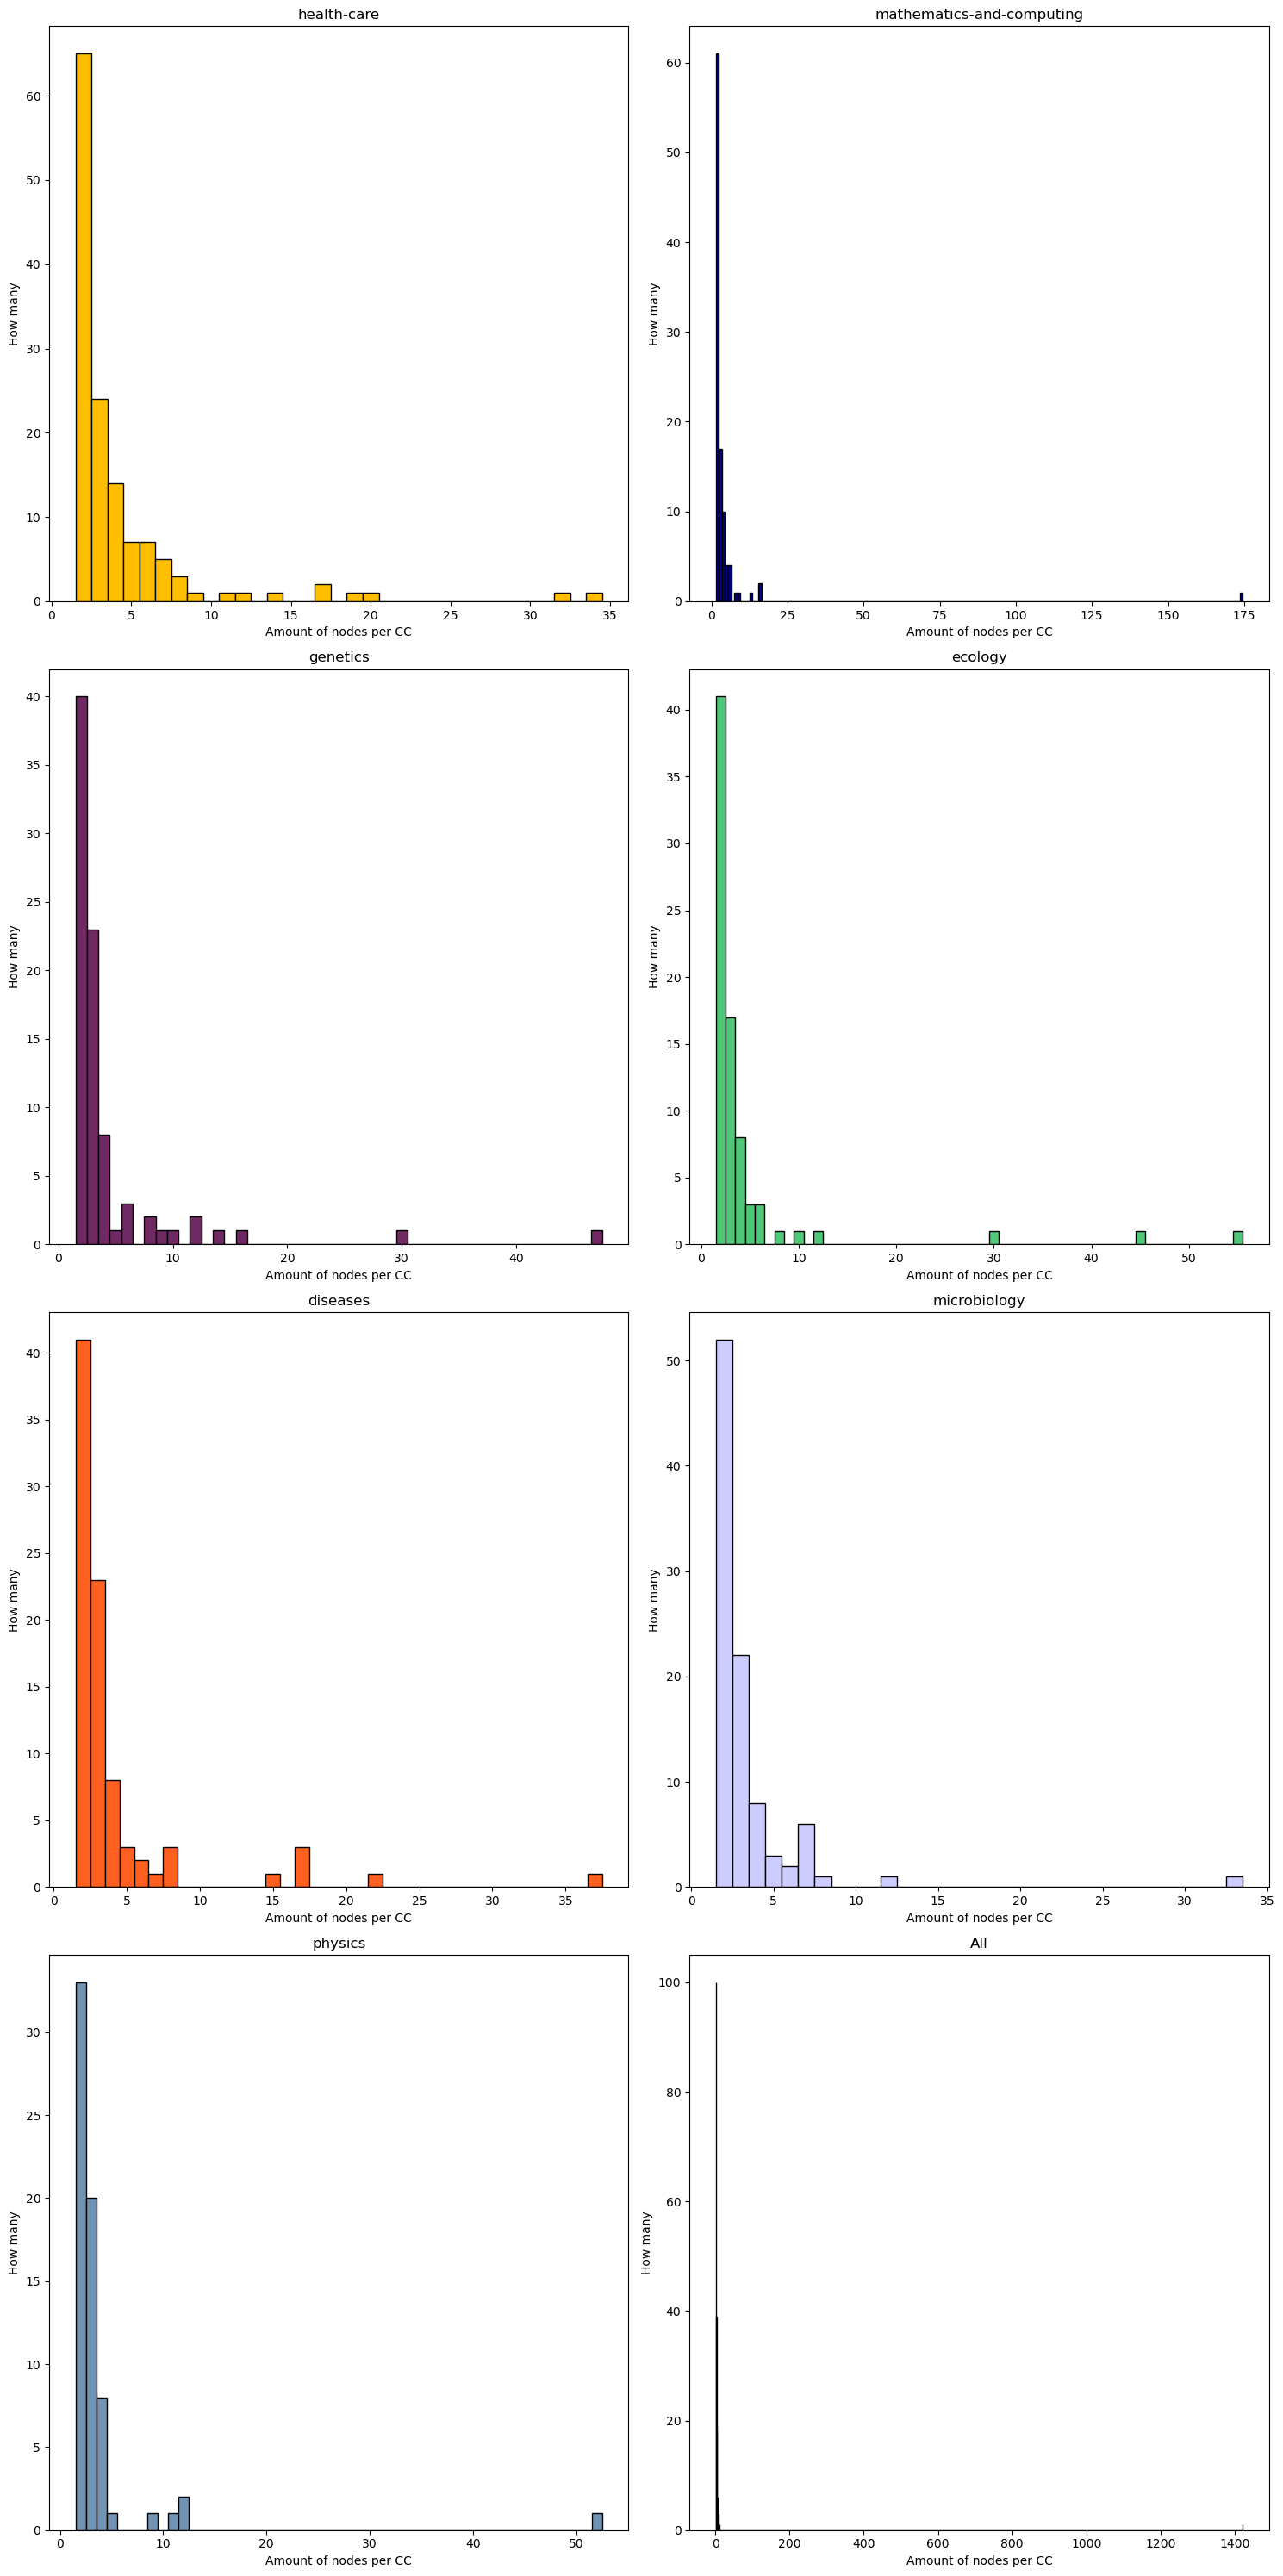

In [17]:
subj_cc_size_dict = {}
labels = {'xlabel':'Amount of nodes per CC'}
for subject, graph in graphs.items():
    subj_cc_size_dict[subject] = connected_component_size_distribution(graph, subject)

create_visual_graph(subj_cc_size_dict, labels, 'bar')

We can see that in most cases, there is a component that far exceeds the others in terms of size (except ecology and health-care).

### Centrality measures

After having see all this beautiful graphs, let's try to find the central universities for each subject.

In [18]:
def compute_betweennes_centrality(G,subj,n_first):
    centrality = nx.betweenness_centrality(G, weight='weight') #We should maybe put a seed to stuff, for reproducibility
    centrality_list = sorted(centrality.items(), key=lambda x:x[1], reverse = True)
    
    most_central_universities = centrality_list[:n_first]
    print(f"Most central uni's of \033[1m{subj}\033[0m")
    pprint(most_central_universities)
    print("\n")
    return 

n_first = 3
for subj, graph in graphs.items():
    compute_betweennes_centrality(graph, subj, n_first)

Most central uni's of health-care
[('Kyung Hee University', 0.0015767832262887822),
 ('University of Calgary', 0.0012953290195678638),
 ('Sungkyunkwan School of Medicine', 0.0012911311940414867)]


Most central uni's of mathematics-and-computing
[('Prince Sattam bin Abdulaziz University', 0.02943171211989745),
 ('Princess Nourah Bint Abdulrahman University', 0.025769948142581198),
 ('King Saud University', 0.02312776298286916)]


Most central uni's of genetics
[('Harvard Medical School Boston', 0.006005575371959254),
 ('Duke University', 0.004757167442745386),
 ('University of Oxford', 0.00435469934409489)]


Most central uni's of ecology
[('University of Oxford', 0.013863972555314262),
 ('University of Copenhagen', 0.01147200453214994),
 ('The University of British Columbia', 0.01002423441286627)]


Most central uni's of diseases
[('University of New South Wales', 0.005289402378443474),
 ('University of Technology Sydney', 0.004879196146319434),
 ('University of Calcutta', 0.002711500

TODO: Comments about centrality

### Exponent using the powerlaw package

Let's now try to find the exponent of the degree distributions.

In [19]:
for subj in graphs:
    # Fit the power-law distribution
    fit = powerlaw.Fit(list(map(lambda x: x[2], degrees[subj])), verbose=False)
    exponent = fit.alpha
    print(f"Powerlaw of {subj} is {fit.alpha}");

Powerlaw of health-care is 6.233536337121402
Powerlaw of mathematics-and-computing is 3.4475953165431177
Powerlaw of genetics is 3.2117543181085457
Powerlaw of ecology is 2.633396132482676
Powerlaw of diseases is 3.145244450417228
Powerlaw of microbiology is 6.182782726653853
Powerlaw of physics is 4.725789988624417
Powerlaw of All is 2.924186944030515


c:\Users\floco\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


TODO: Comments about powerlaw

## Part 5: Networks plotting

Now, we'll attempt to visualize our network in both 2D and 3D. 
To facilitate this, we'll begin by defining some utility functions.

### Utilities functions

In [20]:
# Generate colors for x countries
def get_color_map(top_countries):
    dict_color = {}
    colors = plt.cm.get_cmap('hsv', len(top_countries) + 1)
    
    for i, d in enumerate(top_countries):
        dict_color[d] = colors(i)
    
    dict_color['other'] = colors(len(top_countries))

    return dict_color

In [21]:
# Get the 10 biggest countries
def get_10_biggest_countries():
    countries_count = {}
    for node, v in graph.nodes(data=True):
        if 'country' in v:
            if v['country'] not in countries_count:
                countries_count[v['country']] = 0
            countries_count[v['country']] += 1
    
    return list(map(lambda x: x[0], sorted(countries_count.items(), key=lambda x:x[1], reverse=True)[:10]))

### 2D Networks plotting

In [22]:
def drawNetwork2D(G, subj, fig, grid, labels, scaling_factor=1):   
    #We draw only the biggest component/we should use the biggest component in general
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
        
    #color_list = [subj_color_mapping[attr['subject']] for node1, node2, attr in G.edges(data=True)]
    color = subj_color_mapping[subj]
    size_measure = dict(Gcc.degree)
    #pos = nx.kamada_kawai_layout(Gcc)
    pos = nx.spring_layout(Gcc)
    nodes_conf = {'node_size':[v*scaling_factor for v in size_measure.values()], 'linewidths':1, 'edgecolors':'black'}
    edges_conf = {'width':0.7, 'alpha':0.8, 'edge_color':color}

    ax = fig.add_subplot(grid)
    nx.draw_networkx_nodes(Gcc, pos=pos, ax = ax, **nodes_conf)
    nx.draw_networkx_edges(Gcc, pos=pos, ax=ax, **edges_conf)
    ax.set_title(f"{labels['title']} of {subj} network")
    ax.set_axis_off()
    return ax

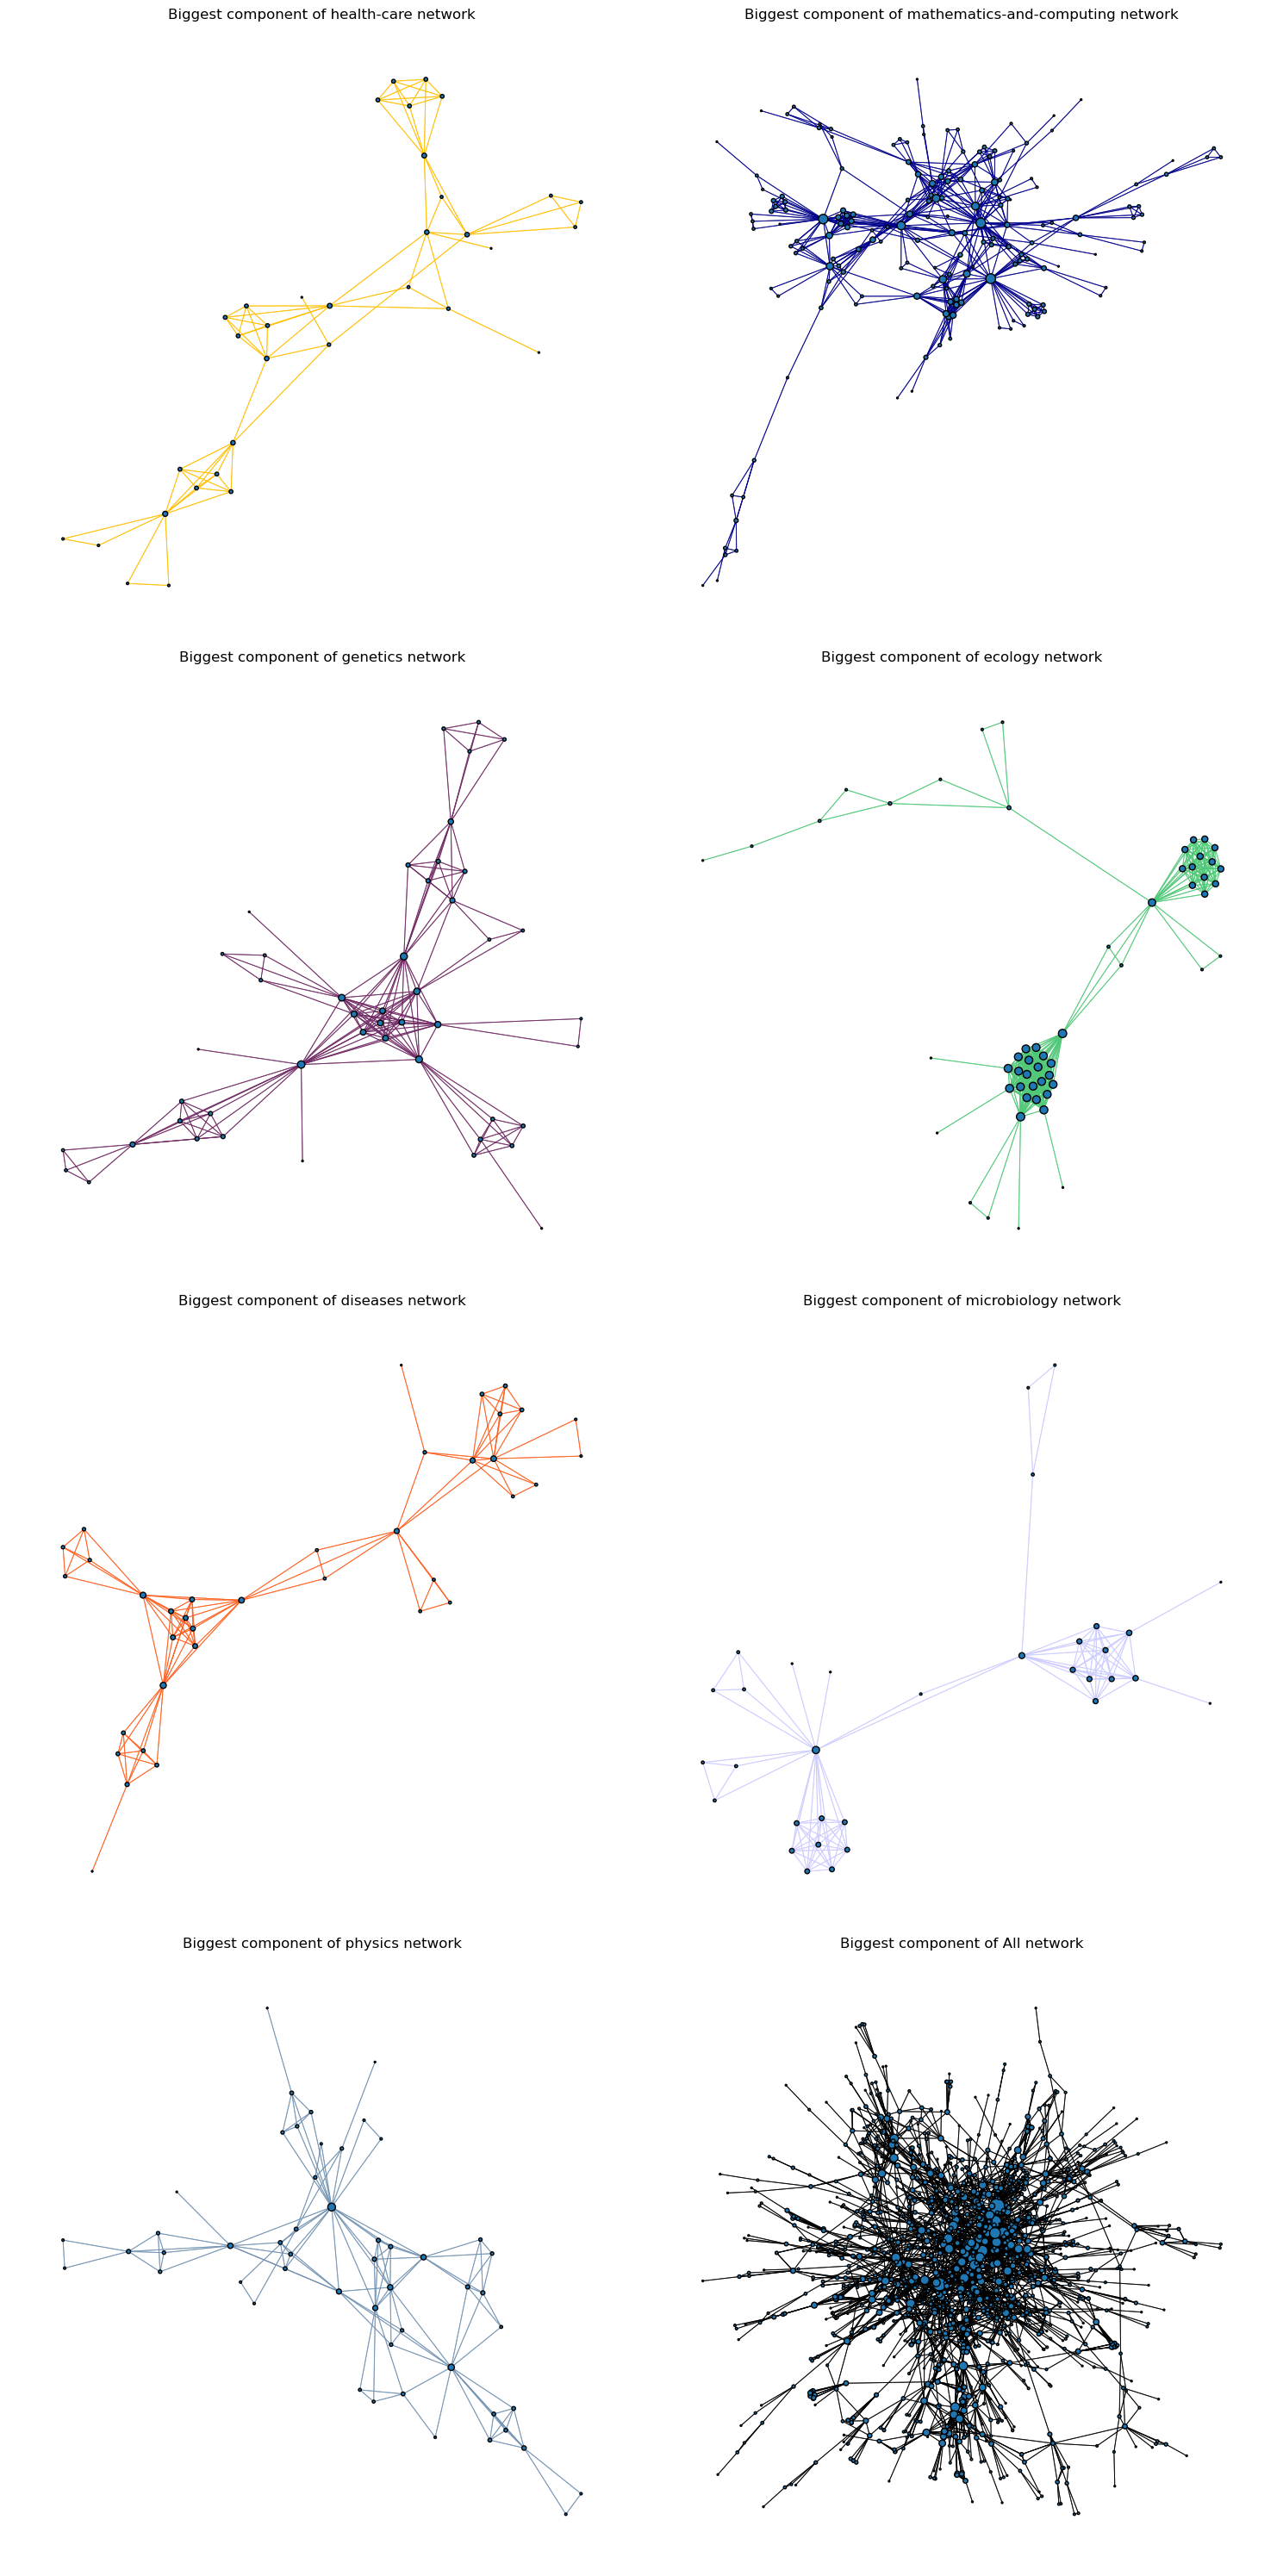

In [23]:
labels = {'title':'Biggest component'}
create_visual_graph(graphs, labels, 'network2d')

TODO: COMMENTS ABOUT 2D

### 3D Networks plotting

In [24]:
def drawNetwork3D(graph, positions, fig, grid, name):

    node_sizes = [4 * get_node_degree(graph, n) for n in graph.nodes]

    top_countries = get_10_biggest_countries()
    dict_color = get_color_map(top_countries)

    node_colors = [dict_color[node['country']] if node['country'] in top_countries else dict_color['other'] for v, node in graph.nodes(data=True)]
    
    ax = fig.add_subplot(grid, projection='3d')

    xs = [pos[0] for pos in positions.values()]
    ys = [pos[1] for pos in positions.values()]
    zs = [node_size for node_size in node_sizes]

    alreadyDisplayed = []  
    i = 0
    for edge in graph.edges():
        node1 = positions[edge[0]]
        node2 = positions[edge[1]]
        alr = 0
        for (n1, n2) in alreadyDisplayed:
            if n1[0] == node1[0] and n1[1] == node1[1] and n2[0] == node2[0] and n2[1] == node2[1]:
                alr = 1
        if not alr:
            x_values = [node1[0], node2[0]]
            y_values = [node1[1], node2[1]]
            z_values = [node_sizes[list(graph.nodes).index(edge[0])], node_sizes[list(graph.nodes).index(edge[1])]]

            ax.plot(x_values, y_values, z_values, alpha=0.3)
            alreadyDisplayed.append((node1, node2))
            alreadyDisplayed.append((node2, node1))
        i = i + 1

    ax.scatter(xs, ys, zs, s=node_sizes, c=node_colors, depthshade=True)

    custom_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in dict_color.items()]
    first_legend = ax.legend(handles=custom_legend, title="Country", loc='upper right')

    ax.set_title(f"{name} biggest component (3D)")

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    return ax

C:\Users\floco\AppData\Local\Temp\ipykernel_31876\3058184773.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('hsv', len(top_countries) + 1)


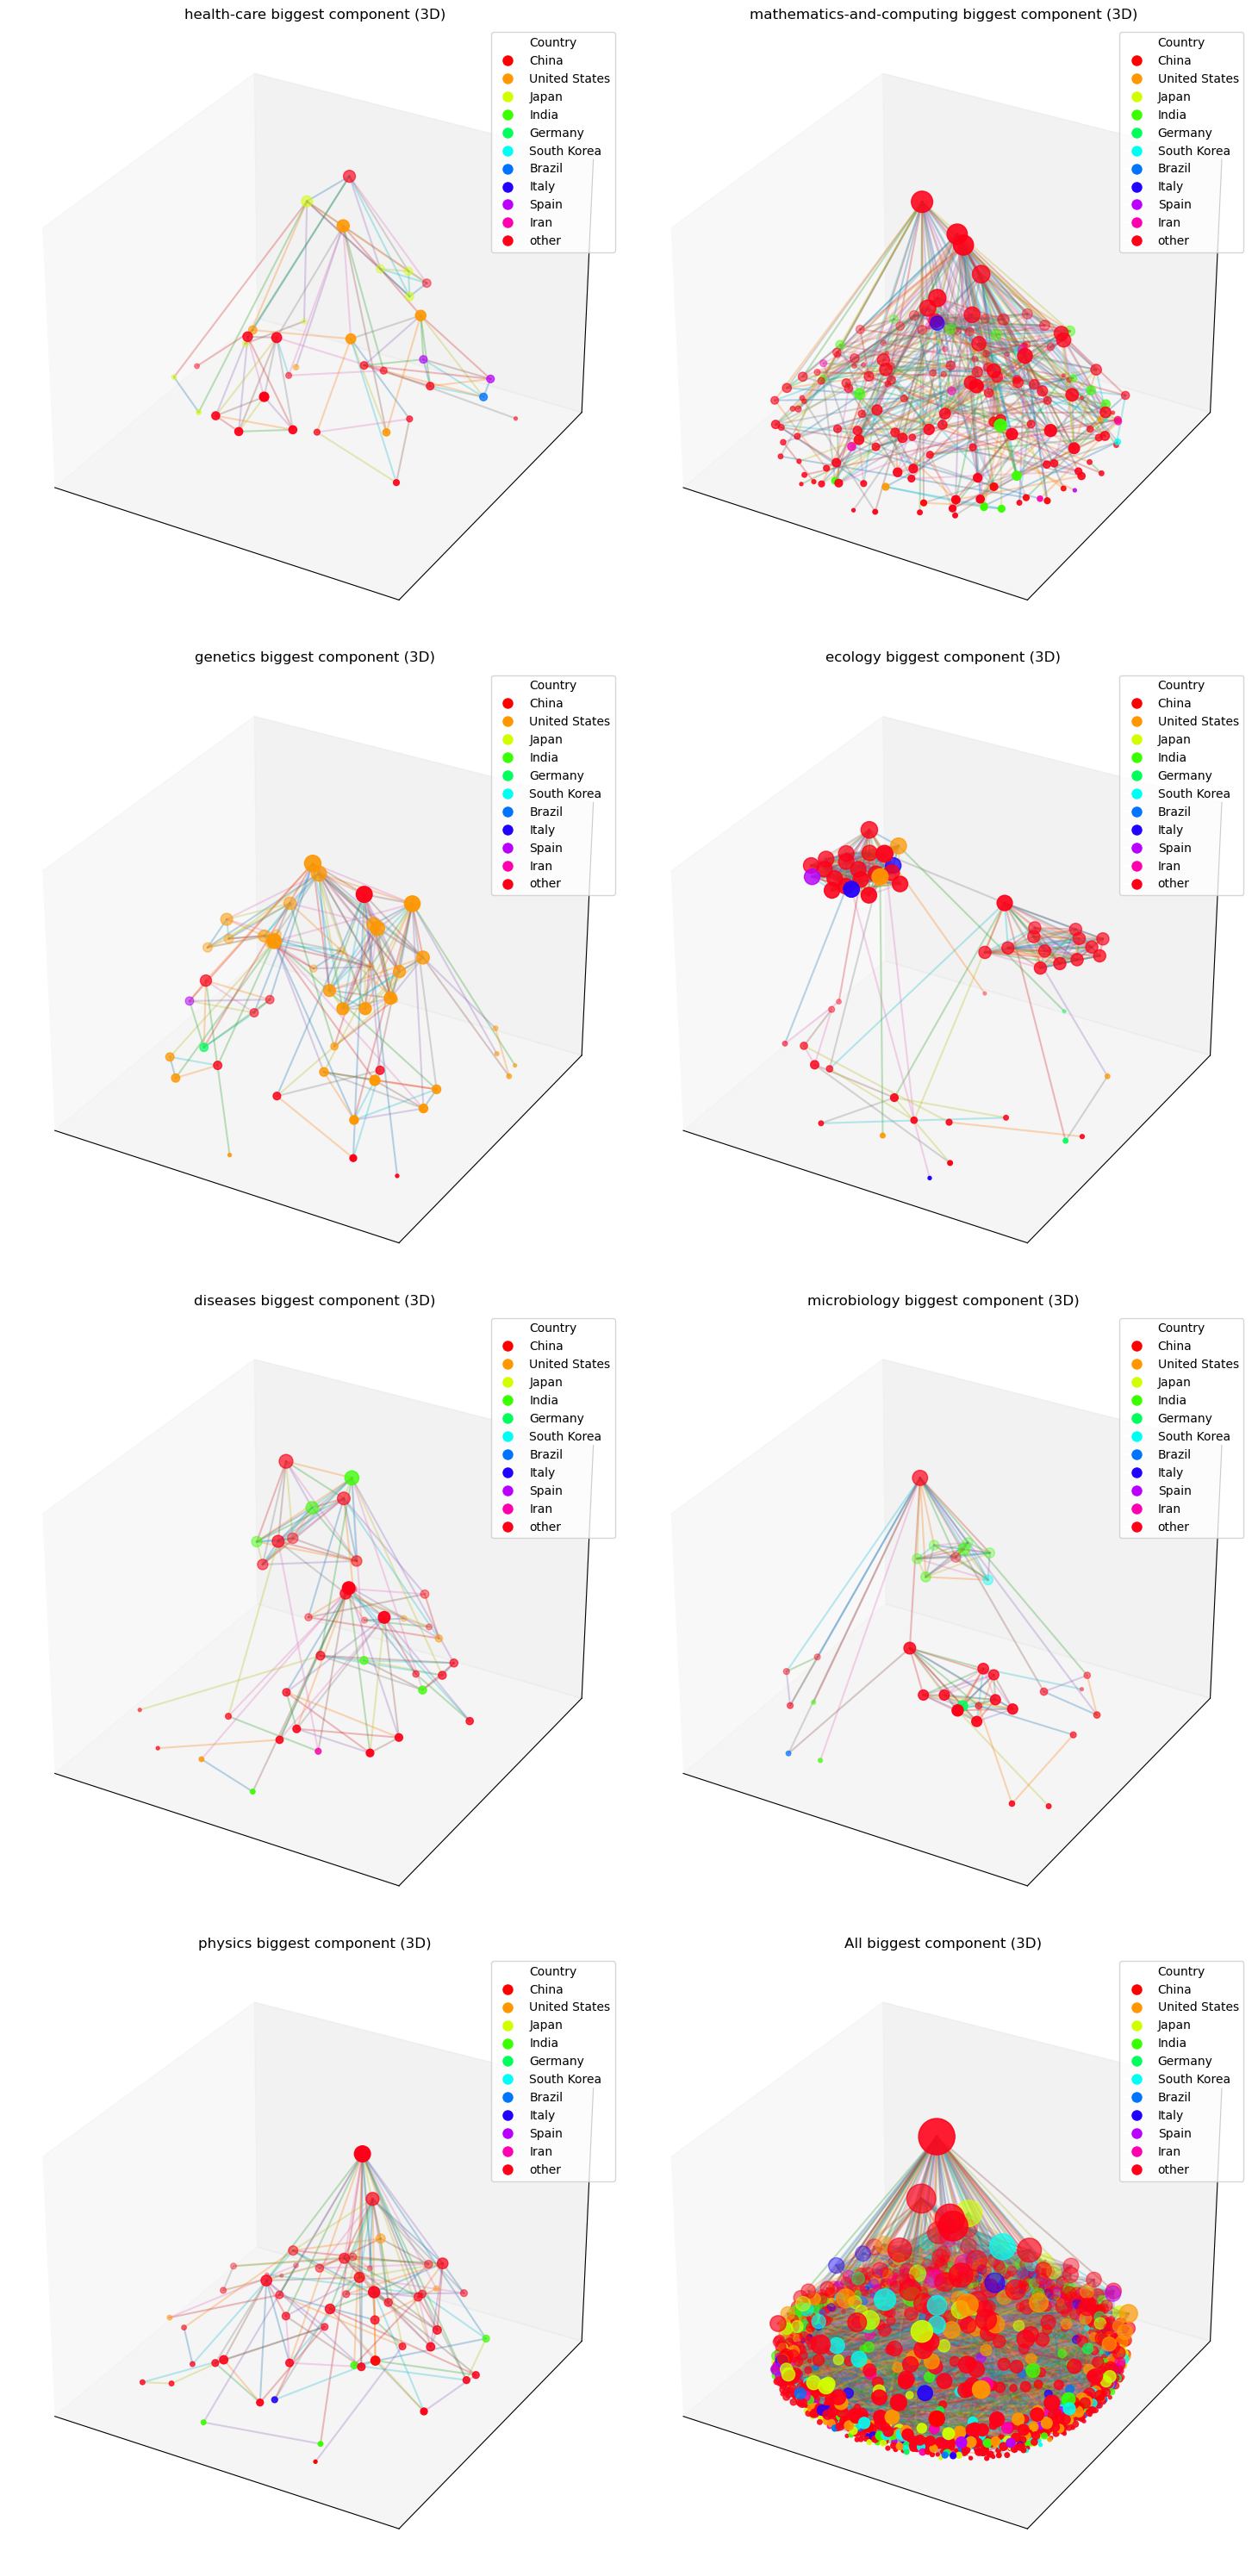

In [25]:
create_visual_graph(graphs, list(subj_color_mapping.keys()), 'network3d')

TODO: COMMENTS ABOUT 2D

## Part 6: Community detection stuff

In [26]:
def compute_modularity(graph, partition_nodes):
        L = len(graph.edges())
        
        #compute k_c
        degrees = [y for x,y in graph.degree(partition_nodes)]
        k_c = sum(degrees)
        
        #get L_c
        comm =graph.subgraph(partition_nodes)
        L_c = len(comm.edges())
        
        #get M_c
        M_c = L_c/L - (k_c/(2*L))**2
        
        return M_c

### Community using algorithm (maybe more than one, and compare them, explaining how they work)

In [27]:
for subj in graphs:
    partition = community_louvain.best_partition(graphs[subj])

    partitions_number = max(partition.values())+1
    print(f"The number of partitions for {subj} is {partitions_number}")

The number of partitions for health-care is 136
The number of partitions for mathematics-and-computing is 110
The number of partitions for genetics is 88
The number of partitions for ecology is 82
The number of partitions for diseases is 88
The number of partitions for microbiology is 97
The number of partitions for physics is 69
The number of partitions for All is 200


### Community split according to countries

### Significance test to see the difference

# Text processing stuff

### Word cloud

### Dictionary based topic analysis